# 1.1 Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing, model_selection, neighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(rc = {"figure.figsize":(10, 6)}) #graph size

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## 1.2 Load Data from Dataset

In [2]:
df = pd.read_csv("card_transdata.csv")
df

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0


In [3]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [4]:
df.shape

(1000000, 8)

In [5]:
df.describe().style.background_gradient(cmap = "plasma")

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [7]:
df.duplicated().sum()

0

In [8]:
df.dtypes

distance_from_home                float64
distance_from_last_transaction    float64
ratio_to_median_purchase_price    float64
repeat_retailer                   float64
used_chip                         float64
used_pin_number                   float64
online_order                      float64
fraud                             float64
dtype: object

## Correlation Heatmap

<AxesSubplot:>

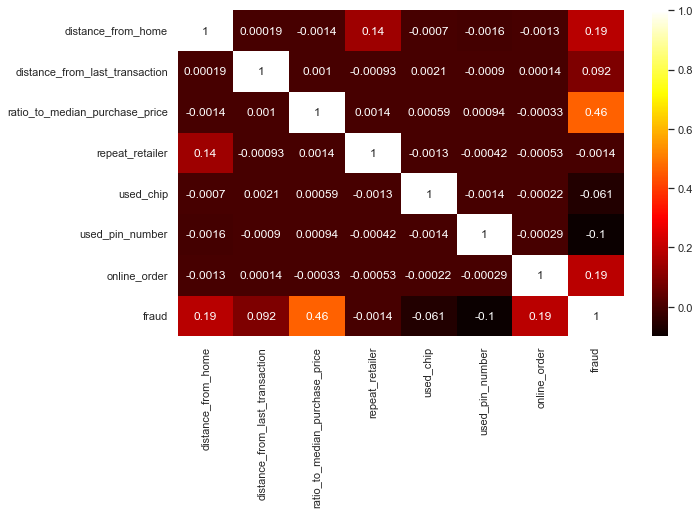

In [9]:
corr = df.corr()

sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True, cmap = "hot")

fraud
0.0    912597
1.0     87403
dtype: int64

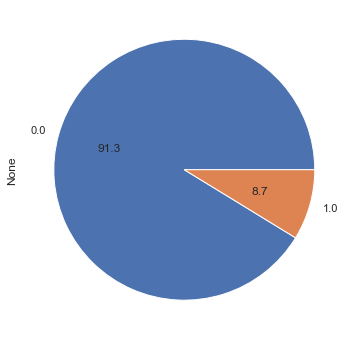

In [10]:
# Class distribution
# Real (class 0.0) meaning non-fraudulent transactions
# Fraud (class 1.0) meaning fraudulent transactions
df.value_counts("fraud").plot.pie(autopct = "%.1f")
df.value_counts("fraud")

In [11]:
real = df[df["fraud"] == 0]
fraud = df[df["fraud"] == 1]

# Resampling the original dataset with 87,403 datapoints for both classes
real_resample = real.sample(n = 87403, random_state = 123)
fraud_resample = fraud.sample(n = 87403, random_state = 123)

# Creating new dataset consisting of equal class occurence 
df0 = pd.concat([real_resample, fraud_resample], axis = 0)

fraud
0.0    87403
1.0    87403
dtype: int64

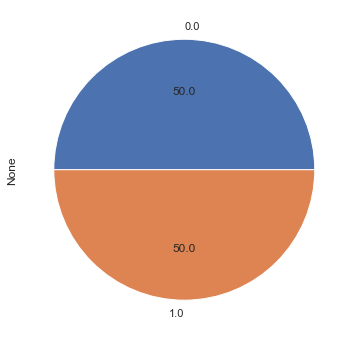

In [12]:
df0.value_counts("fraud").plot.pie(autopct = "%.1f")
df0.value_counts("fraud")

In [13]:
x = np.array(df0.drop(columns = "fraud"))
y = np.array(df0["fraud"])

In [14]:
# Creating Train Test Split
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 123, shuffle = True)

In [16]:
# Data scaling to produce good results
scale = MinMaxScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

##  Training the Models

In [17]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(x_train,y_train)

tree = DecisionTreeClassifier()
tree.fit(x_train,y_train)

forest = RandomForestClassifier(random_state = 5)
forest.fit(x_train, y_train)

RandomForestClassifier(random_state=5)

## Predictions of Models


In [18]:
knn_pred = knn.predict(x_test)
tree_pred = tree.predict(x_test)
forest_pred = forest.predict(x_test)

## Accuracy of Models


In [19]:
print("accuracy of KNN                 ", accuracy_score(y_test, knn_pred))
print("\naccuracy of Decision Tree       ", accuracy_score(y_test,tree_pred))
print("\naccuracy of Random Forest       ", accuracy_score(y_test,forest_pred))

accuracy of KNN                  0.9964818946284537

accuracy of Decision Tree        0.999942795034609

accuracy of Random Forest        0.999942795034609


## Precision Score of Models

In [20]:
print("Precision Score of KNN                 ", precision_score(y_test, knn_pred))
print("\nPrecision Score of Decision Tree       ", precision_score(y_test,tree_pred))
print("\nPrecision Score of Random Forest       ", precision_score(y_test,forest_pred))

Precision Score of KNN                  0.9940723852949558

Precision Score of Decision Tree        0.9998854655824075

Precision Score of Random Forest        0.9998854655824075


## Confusion Matrix of  Models

In [21]:
# confusion matrix of KNN
confusion_matrix(y_test, knn_pred)

array([[17398,   104],
       [   19, 17441]], dtype=int64)

Text(84.5, 0.5, 'Truth')

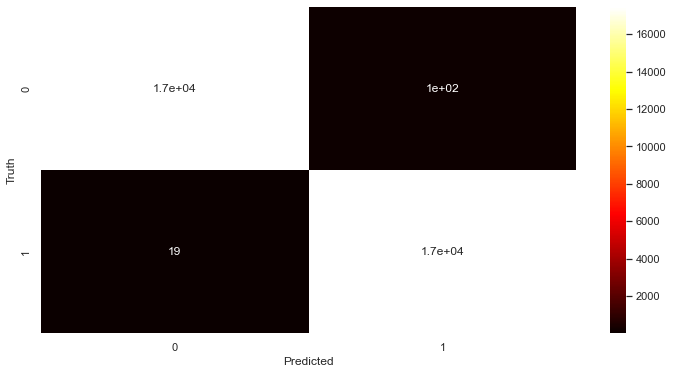

In [22]:
cm=confusion_matrix(y_test, knn_pred)
plt.figure(figsize = (12, 6))

sns.heatmap(cm, annot = True, cmap = "hot")
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [23]:
# confusion matrix of Decision Tree
confusion_matrix(y_test, tree_pred)

array([[17500,     2],
       [    0, 17460]], dtype=int64)

Text(84.5, 0.5, 'Truth')

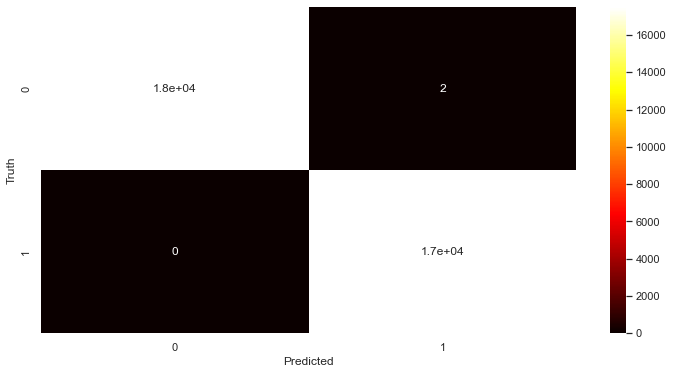

In [24]:
cm=confusion_matrix(y_test, tree_pred)
plt.figure(figsize = (12, 6))

sns.heatmap(cm, annot = True, cmap = "hot")
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [25]:
# confusion matrix of Random Forest
confusion_matrix(y_test, forest_pred)

array([[17500,     2],
       [    0, 17460]], dtype=int64)

Text(84.5, 0.5, 'Truth')

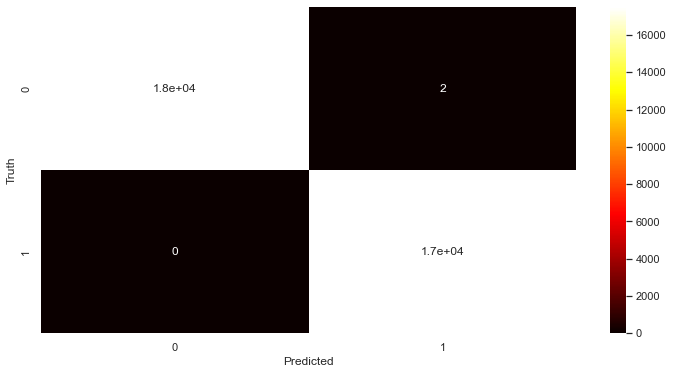

In [26]:
cm=confusion_matrix(y_test, forest_pred)
plt.figure(figsize = (12, 6))

sns.heatmap(cm, annot = True, cmap = "hot")
plt.xlabel("Predicted")
plt.ylabel("Truth")

## Classification Report of Models

In [27]:
print(classification_report(y_test, knn_pred) )
print(classification_report(y_test, tree_pred) )
print(classification_report(y_test, forest_pred) )

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     17502
         1.0       0.99      1.00      1.00     17460

    accuracy                           1.00     34962
   macro avg       1.00      1.00      1.00     34962
weighted avg       1.00      1.00      1.00     34962

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17502
         1.0       1.00      1.00      1.00     17460

    accuracy                           1.00     34962
   macro avg       1.00      1.00      1.00     34962
weighted avg       1.00      1.00      1.00     34962

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17502
         1.0       1.00      1.00      1.00     17460

    accuracy                           1.00     34962
   macro avg       1.00      1.00      1.00     34962
weighted avg       1.00      1.00      1.00     34962

